# Calculate $w_p$



In [5]:
# if __name__ == "__main__":
#     import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('input_file')
#     parser.add_argument('header_file')
#     parser.add_argument('output_file')
#     parser.add_argument('pimax')
#     parser.add_argument('rp_min')
#     parser.add_argument('rp_max')
#     parser.add_argument('nbins')
#     args = parser.parse_args()

In [10]:
import os.path
import numpy as np
import pandas as pd

In [9]:
project_path = "/global/cfs/cdirs/des/zhou/spt_lensing/"
infile_path = os.path.join(project_path,"data/results.npz")

In [13]:
infile = np.load(infile_path) 

In [16]:
infile.files

['arr_0']

In [17]:
infile['arr_0']

array([(5.0000e-02, 6.0000e-02, 0., 18446744073709551615, 0.),
       (6.0000e-02, 7.0000e-02, 0.,                  130, 0.),
       (7.0000e-02, 8.0000e-02, 0.,                   48, 0.),
       (8.0000e-02, 9.0000e-02, 0.,                   38, 0.),
       (9.0000e-02, 1.1000e-01, 0.,                   45, 0.),
       (1.1000e-01, 1.3000e-01, 0.,                   10, 0.),
       (1.3000e-01, 1.5000e-01, 0.,                   25, 0.),
       (1.5000e-01, 1.7000e-01, 0.,                   13, 0.),
       (1.7000e-01, 2.0000e-01, 0.,                   31, 0.),
       (2.0000e-01, 2.4000e-01, 0.,                   39, 0.),
       (2.4000e-01, 2.8000e-01, 0.,                   13, 0.),
       (2.8000e-01, 3.3000e-01, 0.,                   29, 0.),
       (3.3000e-01, 3.8000e-01, 0.,                   20, 0.),
       (3.8000e-01, 4.5000e-01, 0.,                   30, 0.),
       (4.5000e-01, 5.2000e-01, 0.,                   33, 0.),
       (5.2000e-01, 6.1000e-01, 0.,                   4

# Calculate $w_p$ from $\xi$

$\begin{equation}
w_{p, A B}\left(r_{p}\right)=2 \int_{0}^{\Pi_{\max }} \xi_{A B}(r, \pi) d \pi
\end{equation}$

In [3]:
#Script passed on from A. Salcedo
import numpy as np
import scipy.integrate as integrate

def wp(rp,binmin,binmax,xi,pimax=None):
    """compute wp(r_p) from tabulated xi(r)."""
    
    lower_bound = rp 
    upper_bound = np.sqrt(rp**2 + pimax**2)
    binmask = np.logical_and(binmax > lower_bound, binmin < upper_bound)
    masked_xi = xi[binmask]
    r_i = binmin[binmask]
    r_iplus = binmax[binmask]
    s_plus = np.minimum(upper_bound, r_iplus)
    s_minus = np.maximum(lower_bound, r_i)
    # here we assume that xi is piecewise constant over the tabulated input bins
    elementwise_integral = 2.0*masked_xi * \
                           (np.sqrt(s_plus**2 - rp**2) - np.sqrt(s_minus**2 - rp**2))
    w_p = np.sum(elementwise_integral)

    return w_p

# Calcualte $\Delta \Sigma $ from $ w_p$ 

$\begin{equation}
\Delta \Sigma\left(r_{p}\right)=\Omega_{m} \rho_{\text {crit }}\left[\frac{2}{r_{p}^{2}} \int_{0}^{r_{p}} r^{\prime} w_{p, c m}\left(r^{\prime}\right) d r^{\prime}-w_{p, c m}\left(r_{p}\right)\right]
\end{equation}$

In [4]:
def DeltaSigma(binmin,binmax,xi,pimax=None,mean_rho=None,H0=None, rp_min=None, rp_max=None, nbins=None):
    # mean rho (in comoving Msun pc^-2, no little h)
    h = H0/100.

    # compute rp bins
    #nbins = 40
    #rp_min = 0.1
    #rp_max = 125.0
    rp_bins = np.logspace(np.log10(rp_min), np.log10(rp_max), nbins+1)
    rp_binmin = rp_bins[0:-1]
    rp_binmax = rp_bins[1:]
    rp_mid = (rp_binmin + rp_binmax)/2.0

    ds = np.zeros(rp_mid.shape[0])
    integrand = lambda r: r*wp(r,binmin,binmax,xi,pimax=pimax)
    for i in range(rp_mid.shape[0]):
        integral, abserr = integrate.quad(integrand, 0., rp_mid[i], epsabs=1.0e-2, epsrel=1.0e-2)
        ds[i] = (integral * (2.0/rp_mid[i]**2) - wp(rp_mid[i],binmin,binmax,xi,pimax=pimax)) * mean_rho

    # convert Mpc/h unit to pc (no h)
    #ds *= 1.0e6 / h
    ds *= 1.0e6 / h**2.0 #delta sigma comes out in Msun h / pc^2 units
    return rp_binmin, rp_binmax, ds

In [43]:
def DeltaSigma_from_files(header_file,filename,output_file,pimax,rp_min,rp_max,nbins):
    # read in cosmological parameters from header_file
    # import config
    # cf = config.AbacusConfigFile(header_file)
    # omega_m = cf.Omega_M # at z=0
    # H_0 = cf.H0
    h = 0.6726
    H_0 = 67.26
    omega_m = 0.14212
    
    # compute mean_rho (comoving density units = Msun pc^-3)
    speed_of_light_km_s = 2.998e5 # km/s
    csq_over_G = 2.494e12 # 3c^2/(8*pi*G) Msun pc^-1
    
    mean_rho = omega_m * csq_over_G * (H_0/speed_of_light_km_s)**2 / 1.0e12 # Msun pc^-3

    binmin,binmax,xi = np.loadtxt(filename,unpack=True)
    
    DS_binmin, DS_binmax, DS = DeltaSigma(binmin,binmax,xi,pimax=float(pimax),mean_rho=mean_rho,H0=H_0,rp_min=float(rp_min),rp_max=float(rp_max),nbins=int(nbins))
    np.savetxt(output_file, np.c_[DS_binmin, DS_binmax, np.zeros(DS.shape[0]), DS],
               delimiter='\t')

In [44]:
pimax = 100 #h^-1 Mpc
rp_min = 0.05
rp_max = 12
nbins = 20

In [45]:
headerfile = ""
filename = os.path.join(project_path,"data/result_DD.txt")
output_file = os.path.join(project_path,"data/DSigma.txt")

In [46]:
DeltaSigma_from_files(headerfile,filename,output_file,pimax,rp_min,rp_max,nbins)

In [47]:
DSigma = np.loadtxt(output_file)

In [48]:
DSigma

array([[5.00000000e-02, 6.57628409e-02, 0.00000000e+00, 2.21107466e+15],
       [6.57628409e-02, 8.64950250e-02, 0.00000000e+00, 1.52263931e+16],
       [8.64950250e-02, 1.13763171e-01, 0.00000000e+00, 8.81385011e+15],
       [1.13763171e-01, 1.49627787e-01, 0.00000000e+00, 5.08826973e+15],
       [1.49627787e-01, 1.96798967e-01, 0.00000000e+00, 2.94211771e+15],
       [1.96798967e-01, 2.58841183e-01, 0.00000000e+00, 1.70041278e+15],
       [2.58841183e-01, 3.40442632e-01, 0.00000000e+00, 9.82960162e+14],
       [3.40442632e-01, 4.47769493e-01, 0.00000000e+00, 5.68211131e+14],
       [4.47769493e-01, 5.88931879e-01, 0.00000000e+00, 3.28492633e+14],
       [5.88931879e-01, 7.74596669e-01, 0.00000000e+00, 1.89895032e+14],
       [7.74596669e-01, 1.01879355e+00, 0.00000000e+00, 1.09637968e+14],
       [1.01879355e+00, 1.33997517e+00, 0.00000000e+00, 6.34471321e+13],
       [1.33997517e+00, 1.76241147e+00, 0.00000000e+00, 3.69069742e+13],
       [1.76241147e+00, 2.31802371e+00, 0.00000000e

In [49]:
bins = (DSigma[:,0]+DSigma[:,1])/2

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

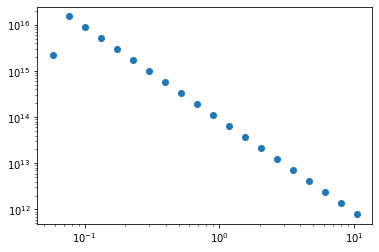

In [51]:
plt.scatter(bins,DSigma[:,3])
plt.xscale('log')
plt.yscale('log')

In [52]:
print(bins)

[ 0.05788142  0.07612893  0.1001291   0.13169548  0.17321338  0.22782008
  0.29964191  0.39410606  0.51835069  0.68176427  0.89669511  1.17938436
  1.55119332  2.04021759  2.6834101   3.52937343  4.64203247  6.10546486
  8.03025429 10.56184672]


In [41]:
DSigma[:,3]

array([4.88753276e+15, 3.36576131e+16, 1.94828252e+16, 1.12475103e+16,
       6.50348762e+15, 3.75872571e+15, 2.17281220e+15, 1.25601843e+15,
       7.26125867e+14, 4.19758864e+14, 2.42352359e+14, 1.40248515e+14,
       8.15820691e+13, 4.68712941e+13, 2.70910160e+13, 1.56454757e+13,
       9.05072953e+12, 5.23175032e+12, 3.02600760e+12, 1.74916750e+12])